In [13]:
from lightning import Trainer
import torch
from torch import nn
import lightning as L
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

class BetaVAE(L.LightningModule):
    def __init__(self, latent_dim: int = 20, beta: float = 1.0):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 2 * latent_dim)  # Output mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat, mu, log_var = self(x)
        x_hat = x_hat.view(x.size(0), 28, 28)
        x = x.view(x.size(0), 28, 28)
        
        recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + self.beta * kl_div
        
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def reconstruct(self, x):
        x = x.view(x.size(0), -1)
        z = self.reparameterize(*self.encode(x))
        x_hat = self.decode(z)
        x_hat = x_hat.view(x.size(0), 28, 28)
        return x_hat

# Prepare the data
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = MNIST("../data", train=True, download=True, transform=transform)
mnist_val = MNIST("../data", train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=32)
val_loader = DataLoader(mnist_val, batch_size=32)

# Initialize our model
beta_vae = BetaVAE()

# Initialize a trainer
trainer = Trainer(max_epochs=5, fast_dev_run=False)

# Train the model
trainer.fit(beta_vae, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 211 K 
1 | decoder | Sequential | 206 K 
---------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.672     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


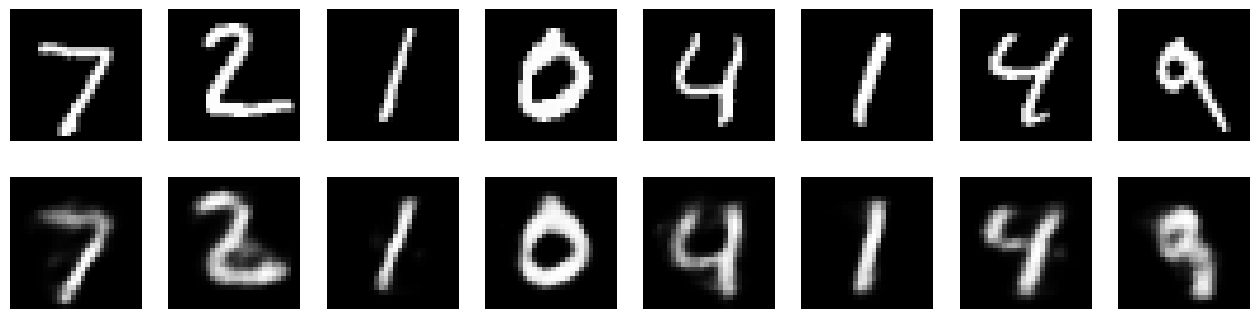

In [15]:
# Function to display a few reconstructions and their ground truth in a grid
def display_reconstructions(model, data_loader, num_images=8):
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            x, _ = batch
            x_hat = model.reconstruct(x)
            x = x[:num_images]
            x_hat = x_hat[:num_images]
            break

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(x[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_hat[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Display reconstructions
display_reconstructions(beta_vae, val_loader)